# Get started with circuit cutting using wire cuts

This guide demonstrates a working example of using wire cuts to get started with the `qiskit-addon-cutting` package. It will cover reconstructing expectation values of a seven-qubit circuit using wire cutting and reducing circuit depth and width using gate cutting.

A wire cut is represented in this package as a two-qubit [`Move`](../api/qiskit-addon-cutting/instructions-move) instruction, which is defined as a reset of the second qubit the instruction acts on followed by a swap of both qubits. This operation is equivalent to transferring the state of the first qubit to the second qubit, while simultaneously discarding the state of the second qubit (as in, the first qubit ends up in the state $|0\rangle$).

The package is designed this way primarily because it is consistent with the way you must treat wire cuts when acting on physical qubits. For example, a wire cut might take the state of physical qubit $n$ and continue it as a physical qubit $m$ after the cut. This choice also has the benefit of allowing you to think of "instruction cutting" as a unified framework for considering both wire and gate cuts within the same formalism (since a wire cut is just a cut [`Move`](../api/qiskit-addon-cutting/instructions-move) instruction).

To demonstrate expectation value reconstruction after wire cutting, first create a circuit with several non-local gates and define observables to estimate.

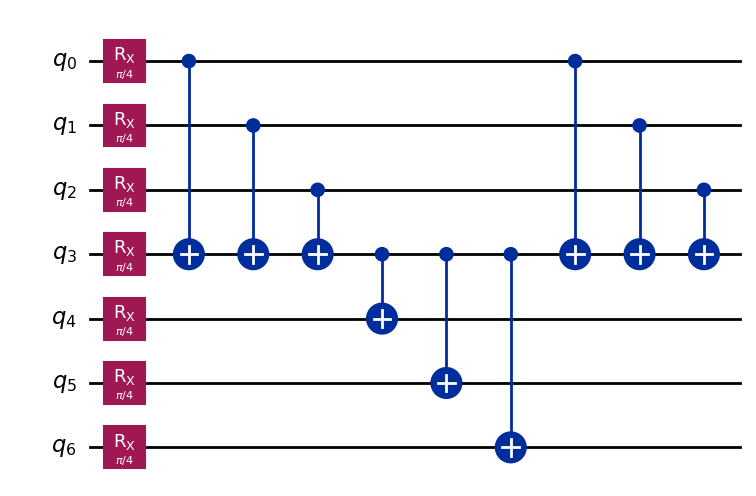

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2, Batch
from qiskit_aer.primitives import EstimatorV2

from qiskit_addon_cutting.instructions import Move
from qiskit_addon_cutting import (
    partition_problem,
    generate_cutting_experiments,
)
from qiskit_addon_cutting import reconstruct_expectation_values


qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

# Define observables
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

# Draw circuit
qc_0.draw("mpl")

The wire to be cut will be made at qubit $q_3$ by manually placing `Move` instructions in a new circuit with one extra qubit, but for this to work properly, it is important that the second (destination) qubit share no entanglement with the remainder of the system; otherwise, the reset operation will cause the state of the remainder to partially collapse. In order to avoid this in this example, we will include a second `Move` instruction which is reversed.

When adding in the `Move` instructions, a new observable should be created to account for the extra qubit wire that was added. This can be done by including an extra $I$ at index $4$.

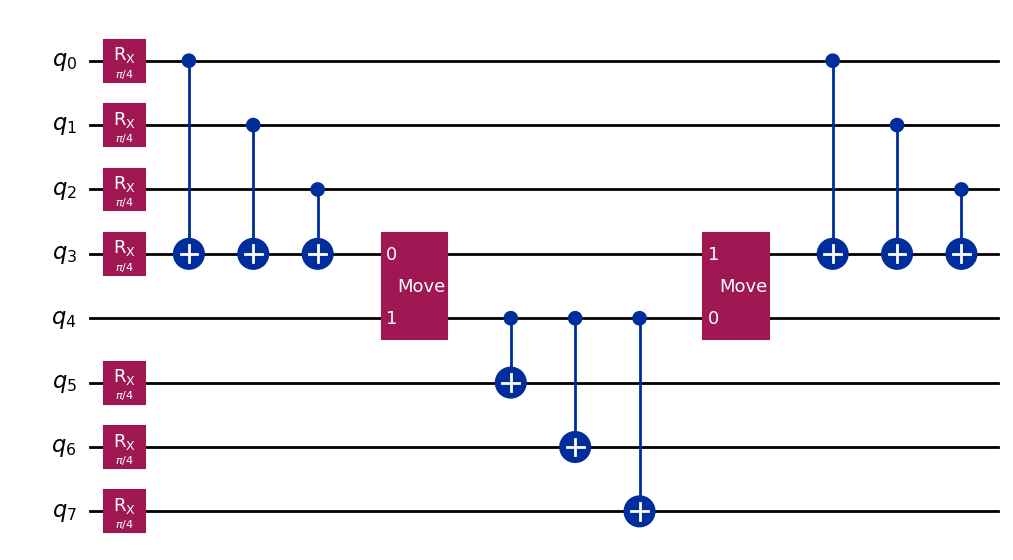

In [2]:
qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

qc_1.draw("mpl")

<Admonition type="information" title="Note">
    As an alternative to working directly with [`Move`](../api/qiskit-addon-cutting/instructions-move) instructions, you may choose to mark wire cuts using a single-qubit [`CutWire`](../api/qiskit-addon-cutting/instructions-cut-wire) instruction. Once the subexperiments are prepared to be executed, use the [`cut_wires`](../api/qiskit-addon-cutting/qiskit-addon-cutting#cut_wires) method to transform `CutWire` to `Move` instructions on newly allocated qubits. However, in contrast to the manual method, this automatic method does not allow for re-use of qubit wires.
</Admonition>

### Separate the circuit and observable

Now that the circuit includes `Move` instructions to represent wire cuts, the problem can be separated into partitions. This is accomplished using the [`partition_problem`](../api/qiskit-addon-cutting/qiskit-addon-cutting#partition_problem) method with a set of partition labels to specify how the circuit is separated. Qubits sharing a common partition label will be grouped together, and any non-local gates spanning more than one partition will be cut.

In this partitioning scheme, we will have cut two wires, which results in a sampling overhead of $4^4$.

Subobservables to measure: 
{'A': PauliList(['IIII', 'ZIII', 'IIIZ']), 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

Sampling overhead: 256.0


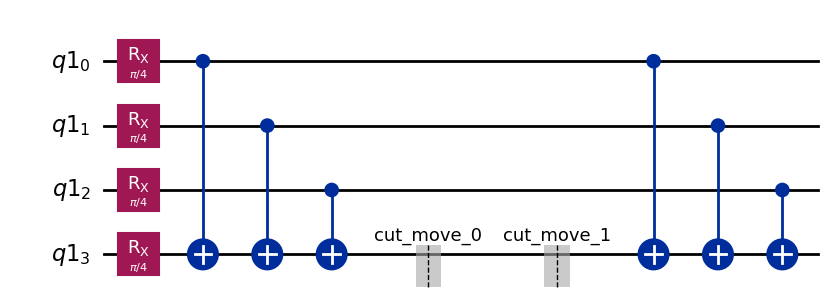

In [3]:
partitioned_problem = partition_problem(
    circuit=qc_1,
    partition_labels="AAAABBBB",
    observables=observable_expanded.paulis,
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

print(f"Subobservables to measure: \n{subobservables}\n")
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
subcircuits["A"].draw("mpl")

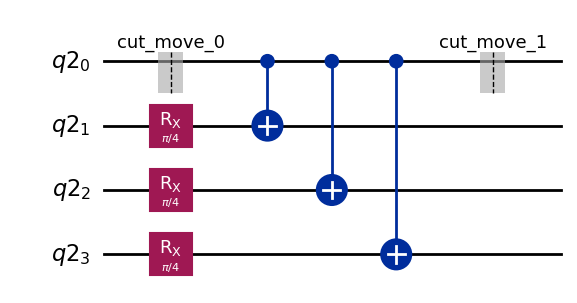

In [4]:
subcircuits["B"].draw("mpl")

### Generate subexperiments to execute and post-process results

To estimate the expectation value of the full-sized circuit, several subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one (or more) QPUs. The [`generate_cutting_experiments`](../api/qiskit-addon-cutting/qiskit-addon-cutting#generate_cutting_experiments) method will accomplish this by ingesting arguments for the `subcircuits` and `subobservables` dictionaries we created above as well as the number of samples to take from the distribution.

The following code block generates the subexperiments and executes them using a local simulator. (To run these on a QPU, change the `backend` to your chosen QPU resource.)

In [5]:
# Generate subexperiments
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

# Set a backend to use and transpile the subexperiments
backend = FakeManilaV2()
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }


# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

Lastly the expectation value of the full circuit can be reconstructed using the [`reconstruct_expectation_values`](../api/qiskit-addon-cutting/qiskit-addon-cutting#reconstruct_expectation_values) method.

The code block below reconstructs the results and compares them with the exact expectation value.

In [6]:
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)


# Compute the exact expectation value using the `qiskit_aer` package.
estimator = EstimatorV2()
exact_expval = estimator.run([(qc_0, observable)]).result()[0].data.evs
print(
    f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}"
)
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(
    f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}"
)
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 1.44399792
Exact expectation value: 1.59099026
Error in estimation: -0.14699234
Relative error in estimation: -0.09239047


###